# Decide threshold

The goal of this notebook is to define a threshold to determine if a sample if PAO1 or not (likewise, if a sample is PA14 or not). We used known labels from SRA to do this. Specifically, we examined the distribution of PAO1 samples (grey) vs non-PAO1 samples (blue). We define the threshold to be one that separated between the two distributions. We use this threshold in [2_create_compendia.ipynb](2_create_compendia.ipynb) to partition gene expression data into PAO1 and PA14 compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Raw (normalized counts) expression data files
pao1_expression_filename = paths.PAO1_GE
pa14_expression_filename = paths.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [4]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

## Format SRA annotations

In [5]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [6]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Label samples with SRA annotations

In [7]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(2588, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX541571,5589.915138,897.177641,1373.180223,1801.831763,139.560966,505.908503,480.986902,662.914591,677.867551,77.256964,...,97.194244,468.526102,12.460801,87.225604,74.764803,77.256964,2275.342185,249.216012,0.000000,NA
ERX541572,6297.494504,831.965260,1747.273260,1807.221548,190.079936,416.713706,320.211585,491.283528,663.817624,45.326754,...,80.418435,485.434914,10.235073,70.183361,46.788907,59.948288,2209.313721,198.852856,0.000000,NA
ERX541573,4948.395849,892.785667,1982.509348,1750.122490,350.549666,362.365947,372.869308,464.773715,615.759526,42.013443,...,114.224049,781.187458,19.693801,153.611651,43.326363,106.346528,1473.096350,101.094848,0.000000,NA
ERX541574,4633.161907,778.582016,2242.316207,1923.696490,313.828444,325.806628,438.401566,438.401566,510.270675,79.056020,...,153.320766,565.370326,21.560733,86.242931,38.330192,64.682198,2129.721269,79.056020,2.395637,NA
ERX541575,4228.807727,868.906226,2124.210932,1775.079310,317.749004,286.366386,274.597904,572.732772,733.568687,56.880994,...,135.337539,672.764866,15.691309,194.179947,21.575550,117.684816,1637.780358,60.803822,0.000000,NA


In [8]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(2588, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
ERX541571,211.451625,56.208660,0.000000,2.676603,10.706411,10.706411,18.736220,72.268277,66.915071,5.353206,...,141.859951,3522.409344,182.008993,21.412823,2.676603,1025.138890,390.784015,152.566362,0.0,NA
ERX541572,221.780416,51.647494,6.076176,15.190439,21.266615,9.114264,12.152352,78.990285,82.028373,3.038088,...,179.247186,2953.021435,221.780416,27.342791,15.190439,1193.968543,568.122437,118.485428,0.0,NA
ERX541573,168.134943,44.835985,18.214619,23.819117,8.406747,18.214619,5.604498,64.451728,57.446106,8.406747,...,208.767554,1820.060757,68.655102,4.203374,12.610121,1548.242600,619.297040,63.050604,0.0,NA
ERX541574,203.805778,13.505202,6.138728,14.732948,4.910983,17.188439,8.594220,47.882080,58.931791,7.366474,...,227.132945,2248.002282,77.347976,6.138728,12.277456,1706.566451,898.709814,165.745663,0.0,NA
ERX541575,193.980790,46.386711,8.433947,29.518816,8.433947,12.650921,4.216974,44.278224,42.169737,6.325461,...,250.909936,1575.039679,65.363092,4.216974,10.542434,1313.587310,710.560070,145.485593,0.0,NA


## Get accessory gene expression

In [9]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [10]:
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [11]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression["median_acc_expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression["median_acc_expression"] = pa14_acc_expression.median(axis=1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
# Add back labels
pao1_acc_expression["Strain type"] = pao1_expression_label["Strain type"]
pa14_acc_expression["Strain type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
pao1_acc_expression.head()

,PA3513,PA2225,PA2730,PA3514,PA2184,PA3154,PA2296,PA1386,PA2734,PA0095,...,PA2230,PA3511,PA3157,PA2185,PA0497,PA3218,PA2771,PA0187,median_acc_expression,Strain type
ERX541571,29.905921,14.952961,902.161962,52.335362,2.492160,4341.342921,39.874562,1131.440692,1290.938940,1241.095737,...,176.943368,9.968640,2988.099978,9.968640,134.576646,0.000000,528.337944,22.429441,89.717764,NA
ERX541572,13.159380,21.932300,693.060691,29.243067,13.159380,3539.873275,20.470147,633.112403,1139.017464,1014.734429,...,128.669495,4.386460,2858.509811,14.621534,140.366722,2.924307,388.932793,5.848613,87.729201,NA
ERX541573,32.823002,6.564600,233.699777,18.380881,18.380881,1954.938026,31.510082,311.162063,708.976853,1072.655720,...,84.026886,3.938760,3412.279334,18.380881,66.958925,2.625840,372.869308,23.632562,91.247947,NA
ERX541574,38.330192,7.186911,323.410991,35.934555,16.769459,2759.773793,59.890924,409.653922,644.426346,689.943448,...,136.551307,9.582548,4745.756844,33.538918,47.912739,14.373822,368.928094,14.373822,104.210208,NA
ERX541575,29.421204,3.922827,304.019108,13.729895,33.344031,2114.403864,25.498377,245.176700,655.112143,894.404603,...,68.649476,7.845654,3622.730924,15.691309,272.636491,11.768482,394.244134,7.845654,82.379371,NA


In [14]:
pa14_acc_expression.head()

,PA14_36020,PA14_33340,PA14_35760,PA14_20600,PA14_32840,PA14_59070,PA14_15350,PA14_00410,PA14_59990,PA14_35930,...,PA14_53680,PA14_33360,PA14_39480,PA14_59520,PA14_31270,PA14_35750,PA14_43090,PA14_22090,median_acc_expression,Strain type
ERX541571,74.944880,10.706411,0.0,0.000000,0.000000,5.353206,0.000000,171.302582,0.000000,0.0,...,8.029809,0.000000,0.000000,2.676603,0.000000,0.0,2.676603,0.000000,0.000000,NA
ERX541572,30.380879,6.076176,0.0,3.038088,3.038088,3.038088,0.000000,173.171010,3.038088,0.0,...,9.114264,3.038088,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.038088,NA
ERX541573,138.711328,2.802249,0.0,4.203374,2.802249,0.000000,0.000000,319.456392,4.203374,0.0,...,0.000000,0.000000,4.203374,1.401125,2.802249,0.0,0.000000,0.000000,1.401125,NA
ERX541574,157.151443,1.227746,0.0,2.455491,2.455491,2.455491,2.455491,244.321384,1.227746,0.0,...,4.910983,1.227746,1.227746,0.000000,0.000000,0.0,0.000000,0.000000,1.227746,NA
ERX541575,109.641316,4.216974,0.0,0.000000,6.325461,0.000000,6.325461,324.706975,2.108487,0.0,...,14.759408,0.000000,0.000000,2.108487,0.000000,0.0,2.108487,2.108487,2.108487,NA


In [15]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression = pao1_acc_expression.merge(
    pa14_acc_expression,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression.head()

,PA3513,PA2225,PA2730,PA3514,PA2184,PA3154,PA2296,PA1386,PA2734,PA0095,...,PA14_53680,PA14_33360,PA14_39480,PA14_59520,PA14_31270,PA14_35750,PA14_43090,PA14_22090,median_acc_expression_pa14,Strain type_pa14
ERX541571,29.905921,14.952961,902.161962,52.335362,2.492160,4341.342921,39.874562,1131.440692,1290.938940,1241.095737,...,8.029809,0.000000,0.000000,2.676603,0.000000,0.0,2.676603,0.000000,0.000000,NA
ERX541572,13.159380,21.932300,693.060691,29.243067,13.159380,3539.873275,20.470147,633.112403,1139.017464,1014.734429,...,9.114264,3.038088,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.038088,NA
ERX541573,32.823002,6.564600,233.699777,18.380881,18.380881,1954.938026,31.510082,311.162063,708.976853,1072.655720,...,0.000000,0.000000,4.203374,1.401125,2.802249,0.0,0.000000,0.000000,1.401125,NA
ERX541574,38.330192,7.186911,323.410991,35.934555,16.769459,2759.773793,59.890924,409.653922,644.426346,689.943448,...,4.910983,1.227746,1.227746,0.000000,0.000000,0.0,0.000000,0.000000,1.227746,NA
ERX541575,29.421204,3.922827,304.019108,13.729895,33.344031,2114.403864,25.498377,245.176700,655.112143,894.404603,...,14.759408,0.000000,0.000000,2.108487,0.000000,0.0,2.108487,2.108487,2.108487,NA


## Plot distribution

In [16]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] == "PAO1",
    "median_acc_expression_pao1",
]

non_pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] != "PAO1",
    "median_acc_expression_pao1",
]

In [17]:
pao1_threshold = 25

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


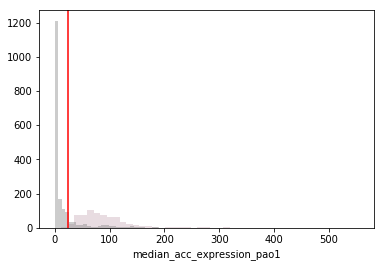

In [18]:
f = sns.distplot(pao1_sra, color="#C6A9B5", kde=False)
f = sns.distplot(non_pao1_sra, color="grey", kde=False)
plt.axvline(pao1_threshold, 0, 100, color="red")

In [19]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] == "PA14",
    "median_acc_expression_pa14",
]

non_pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] != "PA14",
    "median_acc_expression_pa14",
]

In [20]:
pa14_threshold = 25

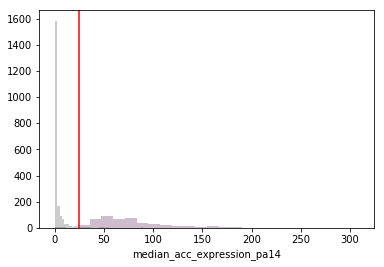

In [21]:
g = sns.distplot(pa14_sra, color="#895881", kde=False)
g = sns.distplot(non_pa14_sra, color="grey", kde=False)
plt.axvline(pa14_threshold, 0, 100, color="red")

**Takeaway:**
Looks like using a threshold of 25 normalized counts separates between SRA-annotated PAO1 samples vs non-PAO1 samples. Similarly for PA14. This is the threshold we'll use to bin samples into PAO1 vs PA14 compendia.